# Use of Word Trends as a Predictor

<i>Author: Brenden Prieto</i>

In this notebook, I compare two time series': historical stock data for Nike (NKE) and the frequency of the
Google search "nke stock price" as found on Google trends.  Some papers suggest that the frequency of searches
for a particular stock is predictive of stock performance, so this notebook will explore if there is any truth to
that claim.

Two methods will be used to analyze the effectiveness of this predictor, but both will have an underlying algorithm: take the gradient of both of the time series, set positive gradients to 1 and negative gradients to -1, then find the accuracy by summing the correct predictions and dividing by the total size of the time series.  The difference in the two methods of analysis will be how the time series are fed into the algorithm.  The first method will use the raw time series data and the second will have smoothed time series data.  In the second method, the data will be smoothed by using a moving average filter.

The stock data was obtained from Yahoo Finance and the word trend data was obtained from Google Trends.  For both series', the time period used was the last 12 months.  For the word trend data, Worldwide search was used.

In [1]:
# Loading packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.signal import hann
from scipy.signal import fftconvolve
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/brendenprieto/anaconda/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [20]:
# Helper functions
def extract(stock_csv, trend_csv):
    # Reading in the data
    historical_data = pd.read_csv(stock_csv)
    word_trend_data = pd.read_csv(trend_csv)
    return historical_data, word_trend_data
    

def clean_data(historical_data, word_trend_data, stock_name):
    # Converting the String dates into Datetime objects for each dataset
    historical_data["Date"] = historical_data["Date"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    word_trend_data["Date"] = word_trend_data["Date"].apply(lambda x: datetime.strptime(x, '%m/%d/%y'))
    
    # Subset Date and closing price of the stock
    hist_df = historical_data[["Date", "Close"]] 
    
    # Indexing the dataframes by date
    stock_data = pd.DataFrame({
        "Close": list(hist_df["Close"])},
        index = list(hist_df["Date"]))

    word_data = pd.DataFrame({
        "Word Frequency": list(word_trend_data[str(stock_name) + " stock price"])},
        index = list(word_trend_data["Date"]))
    
    # Aligning the series' by time (so both have the same time indices)
    stock_dirty, word_dirty = stock_data.align(word_data, join='outer')

    # Interpolating the missing data after alignment
    stock_clean = stock_dirty["Close"].interpolate(method='time')
    word_clean = word_dirty["Word Frequency"].interpolate(method='time')
    
    # Renaming the label of the word frequency series
    word_clean = word_clean.rename("Word Frequency (\"" + str(stock_name) + " stock price\")")
    stock_clean = stock_clean.rename("Closing Price")
    return stock_clean, word_clean

def norm_smoothed_data(stock, word, stock_window, word_window):
    norm_stock = stock/stock.max()
    norm_word = word/word.max()
    
    # Smoothing the data with a hann window
    stock_idxs = norm_stock[~pd.isnull(norm_stock)].index
    smoothed_stock = pd.DataFrame({
            "Closing Price": fftconvolve(norm_stock[~pd.isnull(norm_stock)], hann(stock_window), mode="same")},
            index = stock_idxs)
    
    word_idxs = norm_word[~pd.isnull(norm_word)].index
    smoothed_words = pd.DataFrame({
            "Word Frequency": fftconvolve(norm_word[~pd.isnull(norm_word)], hann(word_window), mode="same")},
            index = word_idxs)

    return smoothed_stock, smoothed_words

def plot_series(stock, word, title):
    big_plot = stock.plot(
        figsize=(18, 7), 
        title=title,
        legend=True)
    word.plot(ax=big_plot, legend=True)

def accuracy(norm_stock_data, norm_word_data):
    """
    Fields: 
        norm_stock_data: normalized stock data
        norm_word_data: normalized word trend data
    Description: This function computes a discrete derivative
        of each time series (using finite difference with n = 1) to 
        observe the change over time of each series.  The changes are
        then normalized to 1 or -1 and compared.  
    Return: The sum of the dates where the changes in word data
        corresponded to the same change in stock data, divided by
        the total number of dates.
    """
    # Computing the finite difference
    delta_norm_stock = norm_stock_data.diff()
    delta_norm_word = norm_word_data.diff()
    
    # Converting trends to 1 and -1
    delta_norm_word[delta_norm_word >= 0] = 1
    delta_norm_word[delta_norm_word < 0] = -1

    delta_norm_stock[delta_norm_stock >= 0] = 1
    delta_norm_stock[delta_norm_stock < 0] = -1
    
    accuracy = sum(delta_norm_word == delta_norm_stock) / len(delta_norm_word)
    
    return accuracy

In [3]:
# Reading in the data
historical_data, word_trend_data = extract("NKE.csv", "g_trends_nke.csv")
stock_clean, word_clean = clean_data(historical_data, word_trend_data, "nke")

### Plotting the Raw Data

The plot below shows the data without any transformations.  The difference in scale of 
the two series' makes it challenging to see if there are any trends, so the following graphs
will try to magnify the stock data.  Additionally, the word frequency data is a relative score - each data
point corresponds to the number of times the term was searched divided by the maximum number of times it
was searched over the year.  To try to get a better comparison of the two series, I'll take the gradient
of both series so that we're just looking at how the two series' change over time.

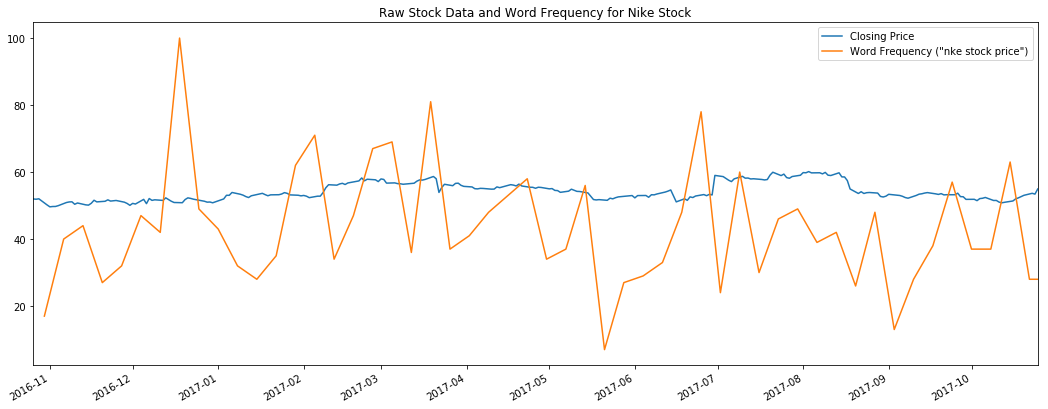

In [4]:
# Plotting Raw Data
plot_series(stock_clean, word_clean, title="Raw Stock Data and Word Frequency for Nike Stock")

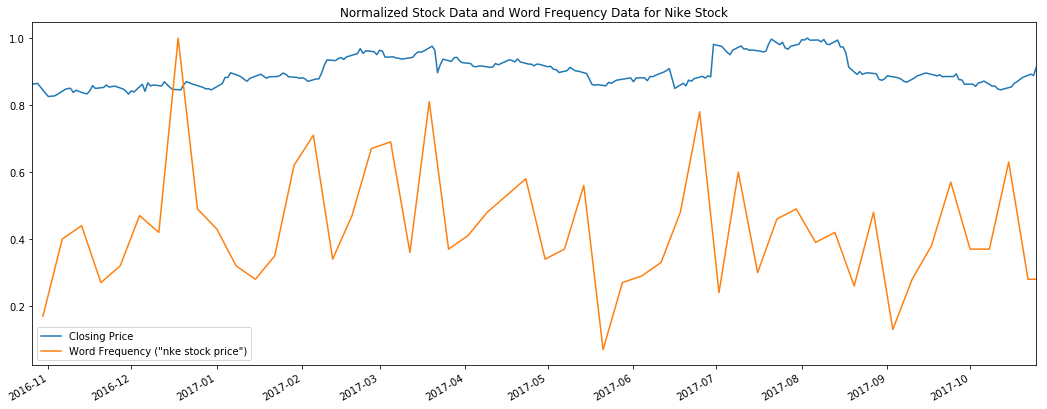

In [5]:
# Plotting Normalized Data
norm_stock = stock_clean/stock_clean.max()
norm_word = word_clean/word_clean.max()

plot_series(norm_stock, norm_word, title="Normalized Stock Data and Word Frequency Data for Nike Stock")

#### Description:

The plot above displays the normalized time series data.  For the Nike Data, this doesn't change the appearance
of the plot that much, but for stock data with larger closing values, this process will be important.

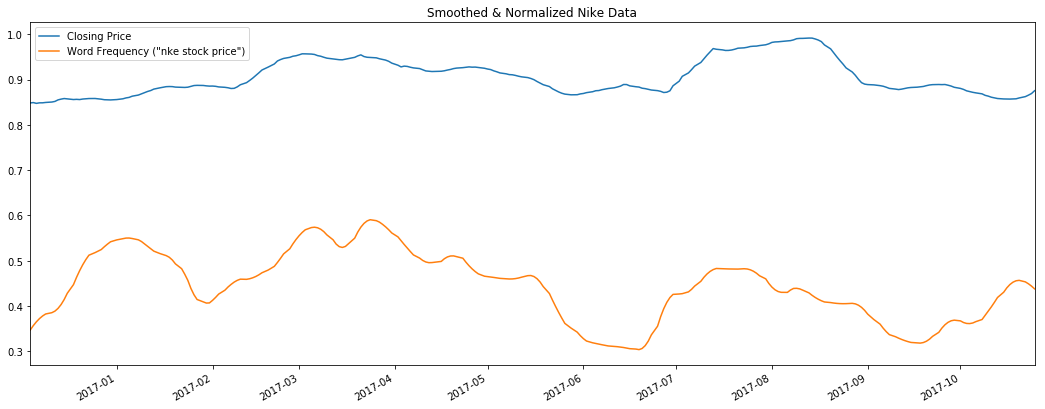

In [6]:
smoothed_stock = pd.rolling_mean(norm_stock, 11)
smoothed_words = pd.rolling_mean(norm_word, 30)

# Removing null data points
nan_idxs = pd.isnull(smoothed_words)
smoothed_stock = smoothed_stock[~nan_idxs]
smoothed_words = smoothed_words[~nan_idxs]

plot_series(smoothed_stock, smoothed_words, title = "Smoothed & Normalized Nike Data")

#### Description: 

The above plot displays the Nike data after it has been smoothed and normalized.  By inspection, certain
regions do show similar trends in both graphs.  For example, July of 2017 and February of 2017 shows a positive slope for both graphs.

In [125]:
score = 100 * accuracy(smoothed_stock, smoothed_words)
print("Accuracy: %.2f" % score + "%")

Accuracy: 56.99%


## What we have so far:

For the Nike data, only 56.99% of the changes in the data from each of the time series' match up.  If the method I used is an accurate metric of this predictor's performance, then this result suggests that word search trends are not much better at predicting stock performance than random chance.

One possible issue with the method used is that it compares changes on a day to day basis.  If we want to examine how 
searches in the past have influenced stock prices in the future, we would need to shift the stock data back in time.

#### Shifting the Stock Data

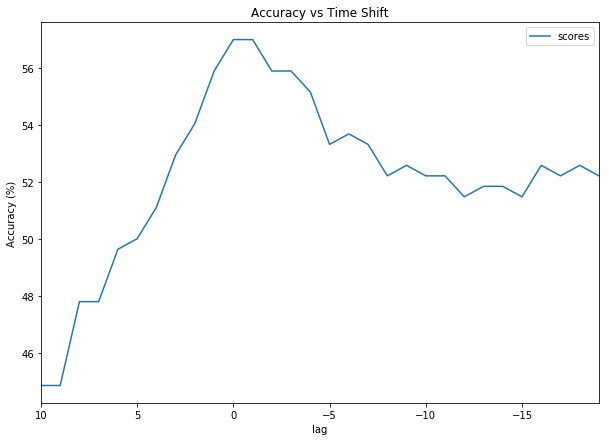

In [132]:
lags = range(10, -20, -1)
scores = [100 * accuracy(smoothed_stock.shift(periods=i), smoothed_words) for i in lags]
scores_df = pd.DataFrame({
        'scores':scores},
        index = lags
    )
ax = scores_df.plot(title="Accuracy vs Time Shift", figsize=(10, 7))
ax.set_xlabel("lag")
ax.set_ylabel("Accuracy (%)")

### Description:

This graph shows that keeping the stock data in the same place (zero lag) produces the highest accuracy score. 
Because this analysis has been tracking day-to-day changes in the data, this also means that the most predictive
data point we could include in our models would be the data point from the day we are trying to predict.  And even if we were to use that point, it's still only 57% predictive.


### Window Size:

The size of the window used for the moving average filter determines how smooth the data will be.  As we increase the smoothness of our data we lose information about the variation in the data.  As such, a moderate size window will be chosen to maintain at least some information about small scale changes.  In practice, a larger window would also require a larger number of datapoints to do prediction.

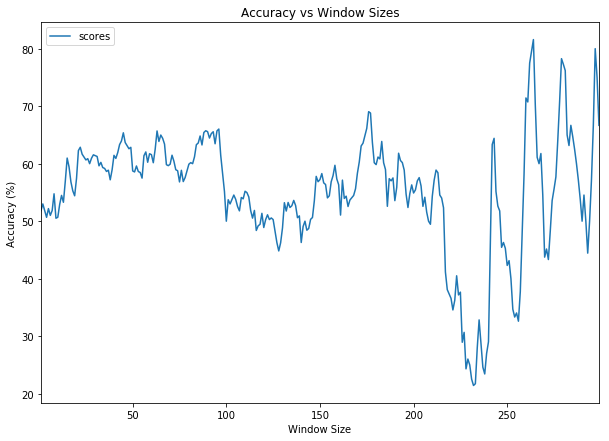

In [165]:
windows = range(1, 300, 1)
nke_scores = []

for window in windows:
    nke_smoothed_stock, nke_smoothed_words = norm_smoothed_data(stock_clean, word_clean, window, window)
    nke_scores += [100 * accuracy(nke_smoothed_stock,nke_smoothed_words)]
    
scores_df = pd.DataFrame({
        'scores':nke_scores},
        index = windows
    )
ax = scores_df.plot(title="Accuracy vs Window Sizes", figsize=(10, 7))
ax.set_xlabel("Window Size")
ax.set_ylabel("Accuracy (%)")

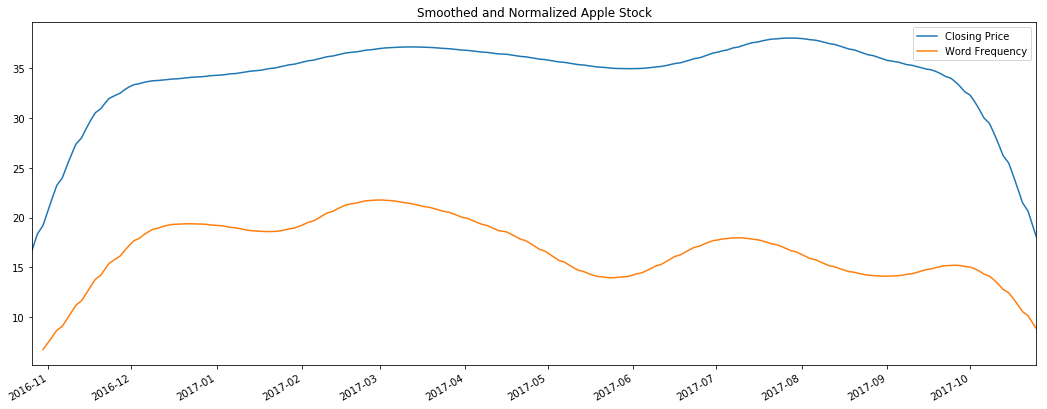

In [21]:
nke_smoothed_stock, nke_smoothed_words = norm_smoothed_data(stock_clean, word_clean, 80, 80)
nke_smoothed_stock_o, nke_smoothed_words_o = norm_smoothed_data(stock_clean, word_clean, 1, 1)

plot_series(nke_smoothed_stock, nke_smoothed_words, title="Smoothed and Normalized Apple Stock")

## Apple Stock Data

While the accuracy score of the shifted data was just as bad as the original, something still seems off with the analysis.  For a 57% accuracy, certain larger scale elements - like the trends and the peaks - of both time series' look strikingly similar.  It may be that the 57% accuracy captured is in the larger scale differences, but because I've only analyzed one stock, it's hard to tell.

To try to reconcile this issue, I'll next look at Apple Stock performance over the last year.  The process used to  gather the data was identical to the process for Nike.

In [95]:
apple_historical_data, apple_word_trend_data = extract("AAPL.csv", "apple_words.csv")
apple_stock_clean, apple_word_clean = clean_data(apple_historical_data, apple_word_trend_data, "apple")

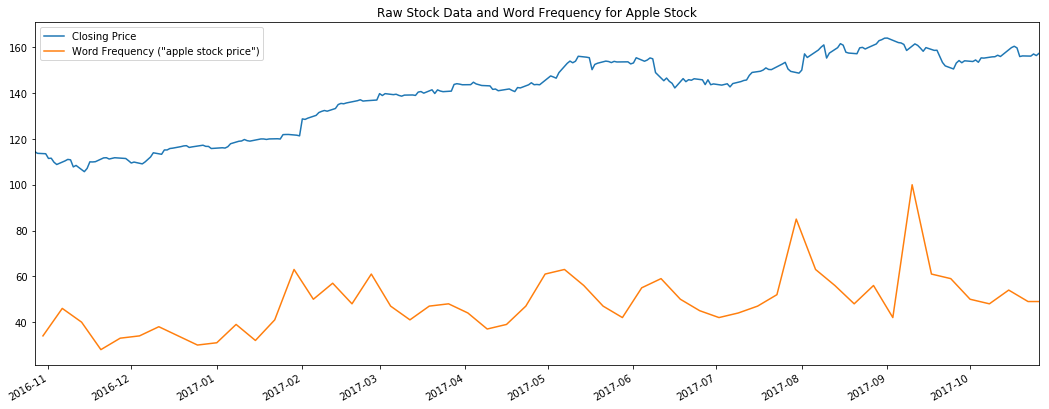

In [96]:
# Plotting Raw
plot_series(apple_stock_clean, apple_word_clean, title="Raw Stock Data and Word Frequency for Apple Stock")

In [138]:
# Normalized the data
apple_norm_stock = apple_stock_clean/apple_stock_clean.max()
apple_norm_word = apple_word_clean/apple_word_clean.max()

# Finding the score of the normalized data
score = 100 * accuracy(apple_norm_stock, apple_norm_word)
print("Accuracy (Normalized): %.2f" % score + "%")

Accuracy (Normalized): 50.66%


#### Description:

From this information alone, it doesn't appear as if this stock will best observe minute trends.  Both of 
these time series plots are increasing over the entire interval.

/Users/brendenprieto/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=11,center=False).mean()
/Users/brendenprieto/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=11,center=False).mean()


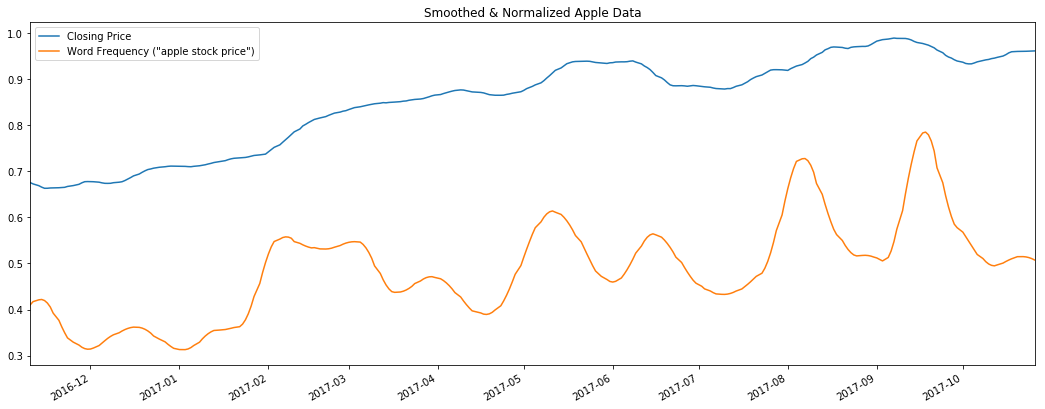

In [134]:
apple_smoothed_stock = pd.rolling_mean(apple_norm_stock, 11)
apple_smoothed_words = pd.rolling_mean(apple_norm_word, 11)

# Removing null data points
nan_idxs = pd.isnull(apple_smoothed_words)
apple_smoothed_stock = apple_smoothed_stock[~nan_idxs]
apple_smoothed_words = apple_smoothed_words[~nan_idxs]

plot_series(apple_smoothed_stock, apple_smoothed_words, title = "Smoothed & Normalized Apple Data")

In [139]:
score = 100 * accuracy(apple_smoothed_stock, apple_smoothed_words)
print("Accuracy (Normalized and Smoothed): %.2f" % score + "%")

Accuracy (Normalized and Smoothed): 55.14%


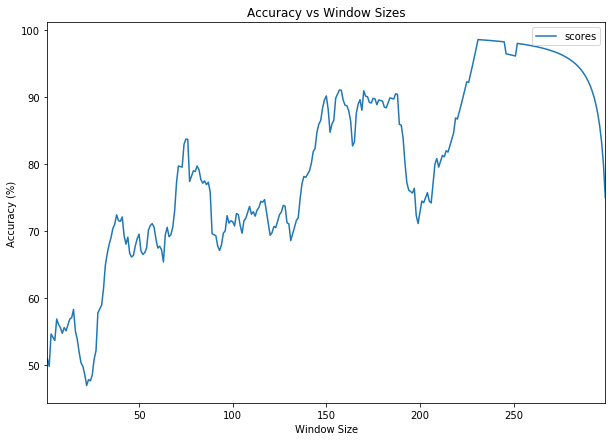

In [154]:
windows = range(1, 300, 1)
apple_scores = []

for window in windows:
    apple_smoothed_stock, apple_smoothed_words = norm_smoothed_data(apple_stock_clean, apple_word_clean, window, window)
    apple_scores += [100 * accuracy(apple_smoothed_stock,apple_smoothed_words)]
    
scores_df = pd.DataFrame({
        'scores':apple_scores},
        index = windows
    )
ax = scores_df.plot(title="Accuracy vs Window Sizes", figsize=(10, 7))
ax.set_xlabel("Window Size")
ax.set_ylabel("Accuracy (%)")

### Description



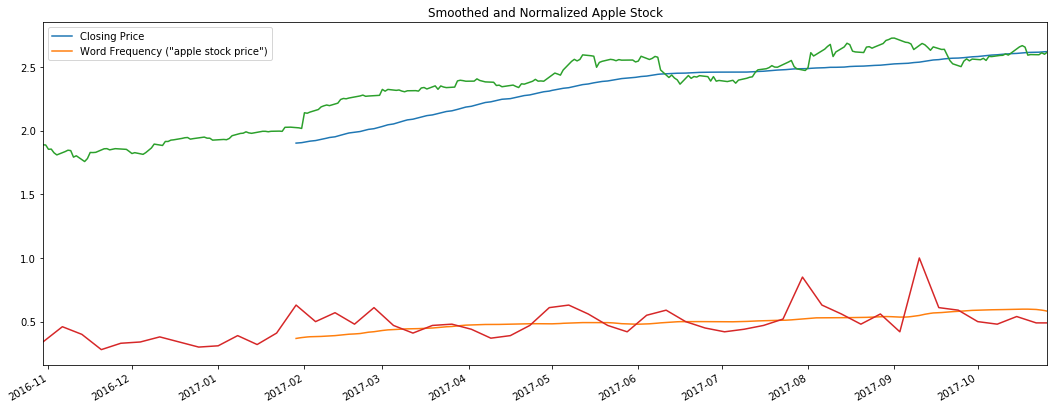

In [161]:
apple_smoothed_stock, apple_smoothed_words = norm_smoothed_data(apple_stock_clean, apple_word_clean, 75, 75)
apple_smoothed_stock_o, apple_smoothed_words_o = norm_smoothed_data(apple_stock_clean, apple_word_clean, 1, 1)

plot_series(apple_smoothed_stock, apple_smoothed_words, title="Smoothed and Normalized Apple Stock")
apple_smoothed_stock_o.plot()
apple_smoothed_words_o.plot()